# Building a Segmentation Pipeline

The goal is to "get my hands dirty" and build an imaging pipeline from scratch. The hope is to gain insight into the bigger picture (i.e. the "what, how, and why") of imaging pipelines in the context of confocal microscopy. 

To that end, I will be working with 2D confocal fluorescence microscopy data and performing single cell segmentation from start to finish, while following along with a Python image processing tutorial from EMBL Bio-IT  found [here](https://github.com/WhoIsJack/python-bioimage-analysis-tutorial). I follow the general structure of the tutorial but pick and choose the parts that I think are most relevant and add my own analysis and justification when I feel the need. That being said, I am a beginner and so my perspective is likely incomplete at best and wrong at worst so please forgive any naivety or faux-pas' on my part.

Now that the stage is set, onto business. From a highlevel, the notebook is organized as follows:
1. Preprocessing: As in "it's better to work with a compressed form of the data while keeping in mind what we want to do."
    - Gaussian smoothing
    - Adaptive thresholding
2. Segmentation: Show me the cells!
    - Connected components labeling
    - Seeding by distance transform
    - Watershed expansion
3. Postprocessing: The icing on the cake.
    - Removing corrupted data
    - Extracting cell edges
4. Simple Data Analysis & Visualization: We're supposed to be doing science right?
    - Boxplots, because duh!
    - A "Spherical Cell": Modeling cell area as a function of membrane length
    - Membrane intensity as a function of area
    - Visualizing cell area as a heatmap

Okay enough talk let's get started!

### Imports
The analysis won't work without loading these packages, so if they are not installed in your environment things will break.

In [1]:
# From standard library
import os

# Libraries containing analysis routines and data structures
## Skimage modules behave weird
import numpy as np
import scipy.ndimage as ndi
import skimage.io
import skimage.filters
import skimage.morphology 
import skimage.feature 

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline

### Load and Display Image Data
It's always a good idea to look at the data you are working with. Yes that might seem obvious, but being methodical when explaining things helps others that are trying to learn, establish an algorithmic workflow.

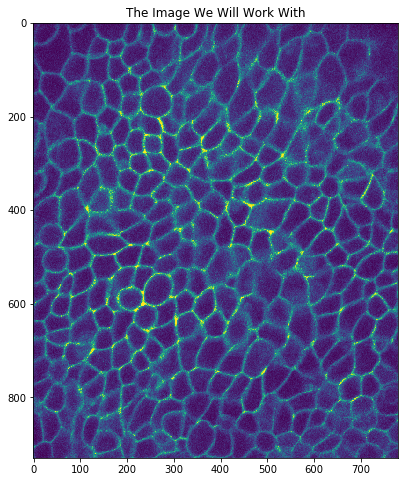

In [2]:
# Compute the filepath for the image we are working with
filename = 'example_cells_1.tif'
dirpath = r'./example_data'
filepath = os.path.join(dirpath, filename)

# Create image format that can be displayed by matplotlib since data is .tif format
img = skimage.io.imread(filepath)

# Plotting
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.title('The Image We Will Work With')
plt.show()

## Preprocessing 
### Smoothing
First we perform Gaussian smoothing on the image. This was one of two points in the tutorial that left me feeling a bit uneasy. The tutorial suggests to utilize a Gaussian kernel for smoothing the image data which seemed pretty ad-hoc. While that may not seem so outlandish upon first analysis (given that it's standard dogma to use a Gaussian when in doubt) it didn't seem justified to me.

That perspective changed after some time & reflection on how background noise might arise from a photomultiplier tube (PMT) in a confocal microscope... 

Huh?! What is this talk of Gaussians, noise and PMT's? (hint: see [dark current](https://en.wikipedia.org/wiki/Dark_current_(physics)))

Well it turns out PMT's generate background [shot noise](https://en.wikipedia.org/wiki/Shot_noise) which can be modeled by a Poisson process. And since the Poisson distribution converges to the Gaussian distribution under sufficiently large samples, it seems reasonable to assume that some Gaussian noise exists throughout the image (assuming shot noise events are sufficiently frequent during the time it takes to generate the image).

But even so, how do we determine the smoothing parameter for the Gaussian (the standard deviation $\sigma$)? Well according to the tutorial the standard procedure is to tune the filter by eye (or train a learning algorithm from ground truth labeled images if you want to be extra fancy). While I can imagine how & why this is done, it bothers me in principle since there should be an algorithmic way to estimate the optimal value for sigma based on the image itself as well as the experimental setup.

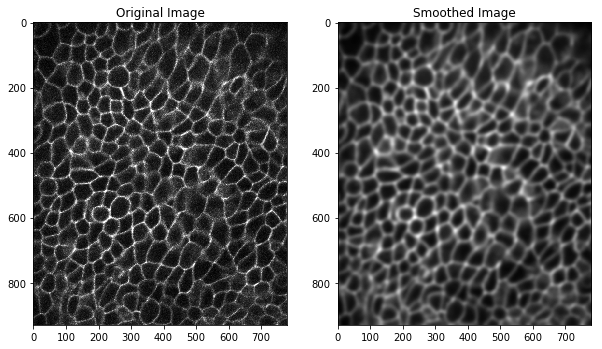

In [3]:
# Set the tuning parameter for the Gaussian filter
## Note that changing this parameter can significantly change downstream analysis!!!!!
sigma = 5

# Smooth the image
img_smoothed = ndi.filters.gaussian_filter(img,sigma=sigma)

# Plotting
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(img_smoothed, cmap='gray')
plt.title('Smoothed Image')
plt.show()

### Adaptive Thresholding
Next we threshold the image to extract background/foreground information in the image. In this context, what that translates to is converting the image into a binary mask format where every pixel with value 1 corresponds to the foreground and every pixel with value 0 corresponds to the background. We do that by assigning a linear boundary in fluorescence space that classifies values greater than or equal to a fixed intensity as being in the foreground and values smaller than the intensity as being in the background.

But why do we threshold the image in the first place? Well, the point of preprocessing (as far as I gather) is essentially to reduce the dimensionality of the image data so that only the relevant information we are interested in remains (one can think of this process as filtering out noise and establishing the scale of interest).

The thresholding process amounts to the conversion of the smoothed image into a binary mask (boolean array). This allows us to distinguish the difference between the contribution of fluorescence from the region of interest (the foreground) and the contribution of fluorescence from "out of focus" signals generated by processes acting at nonlocal scales (the background).

In order to adaptively threshold the image (as opposed to doing it manually which is also described in the tutorial) one uses a circular structure to define a "local neighborhood" of pixels that is used as a kernel in a mean filter. 

This leads us to the second part of the tutorial that bothered me. Why was I bothered? For the same reason as before: we were told to hand-eye-tune a function-parameter combo. The arbitrary parameter this time corresponds to the size of a kernel used in the aribtrary mean filter function and is called $i$ below. I'm not sure how one chooses the value aside from seeing what looks good from a visual perspective but my hunch is that the parameter sets a "length scale" and can be computed based on the actual metric resolution of the image. I sort of get why the mean filter is used and think it is because we want to transform pixels in the image to be closer to the mean of the neighborhood they are in (which will help us distinguish the cutoff intensities for background/foreground fluorescence).

It still all seems a bit unjustified to me, but after going through the tutorial it works, so hey if it ain't broke don't fix it! (at least until it breaks, and it WILL break eventually)

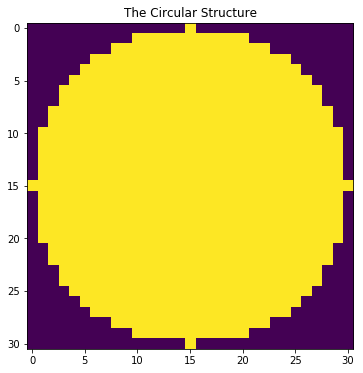

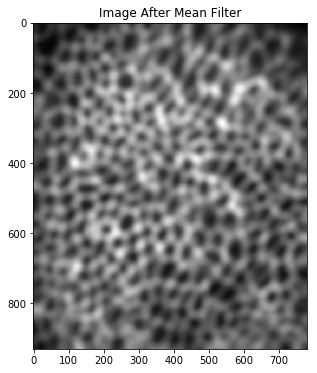

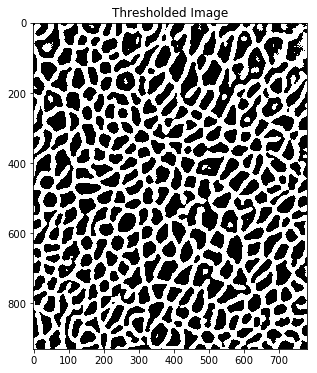

In [4]:
# Generate circular structure
## Note that changing the variable i below can significantly effect the downstream analysis!!!
i = 31
circle_struct = ( (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2 )

# Create mean filter with the circular structure as a kernel
img_mean = skimage.filters.rank.mean(img_smoothed, circle_struct)

# Threshold image by assuming img_mean gives the intensity cutoff
first_threshold = (img_smoothed >= img_mean)

# Plotting
plt.figure(figsize=(6,6))
plt.imshow(circle_struct)
plt.title('The Circular Structure')
plt.show

plt.figure(figsize=(6,6))
plt.imshow(img_mean, cmap='gray')
plt.title('Image After Mean Filter')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(first_threshold, cmap='gray')
plt.title('Thresholded Image')
plt.show()

###  Improving the threshold image by morphological transformations
The final step of preprocessing is to eliminate some of the artifacts generated during our previous thresholding operations. 

If you look closely at the thresholded image in the previous output, you can see there are some speckle-like objects scattered throughout the image. One way to deal with these artifacts is to utilize algorithms from mathematical morphology. In particular, we use an aptly named algorithm from scipy called "binary_fill_holes" which treats the speckles as holes to be filled in.

The final binary threshold mask can be seen below.

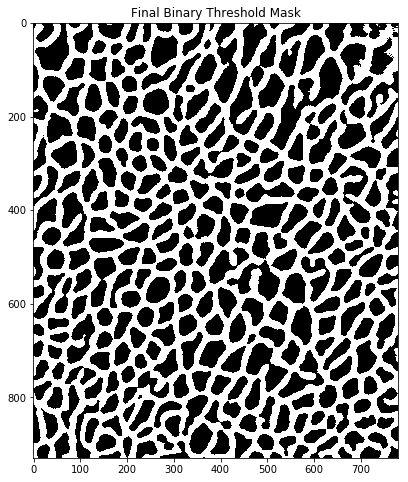

In [5]:
# Fill in the holes
better_threshold = ndi.binary_fill_holes(~first_threshold)

# Plotting
plt.figure(figsize=(8,8))
plt.imshow(~better_threshold, cmap='gray')
plt.title('Final Binary Threshold Mask')
plt.show()

## Segmentation 
### Connected Components Labeling
Now to the fun stuff. Since we've massaged our data into a format that we can use, the next step is to proceed onto the meat of our pipeline: segmentation. As a first point of entry, we take the thresholded image and label each component with a unique ID (a component is just a cluster of foreground values (1's) surrounded by a border of background values (0's)).

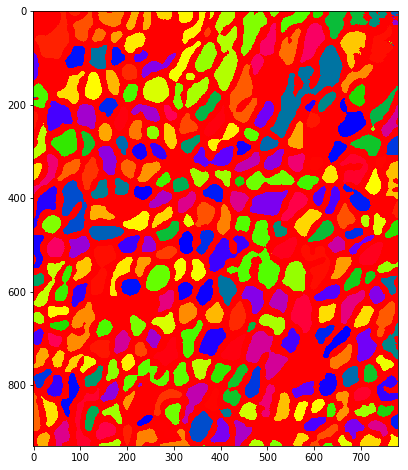

In [6]:
# Label the cells
labeled, _ = ndi.label(better_threshold)

plt.figure(figsize=(8,8))
plt.imshow(labeled, cmap='prism')
plt.show()

### Can we do better?
From my perspective the next few steps are the most confusing part of the analysis (at least without some proper explanatory context). 

The first question is why not just use the labeled segmenation that we already have? The quick answer is that we want to be able to do more analysis with our data. Furthermore, if you look at the previous image you can see cells that were undersegmented. Here is a closeup from a subregion of the previous image demonstrating an example of undersementation:

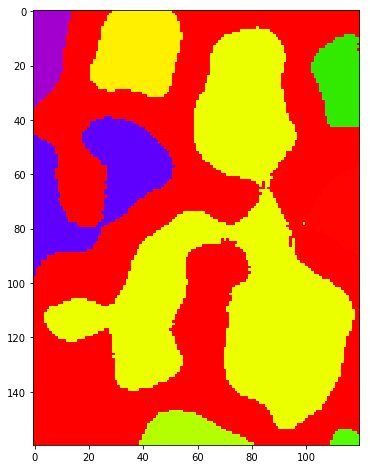

In [7]:
# Plotting
plt.figure(figsize=(8,8))
plt.imshow(labeled[440:600,410:530], cmap='prism')
plt.show()

The way we remedy this situation is by performing another round of segmentation & labeling (thresholding can be thought of as the first round of segmentation) with a classical algorithm known as seeded watershed segmentation. The basic idea of the algorithm is as follows:
1. Perform a distance transform on the unlabeled binary cell mask
    - This just means we compute how far each foreground pixel is from the nearest background pixel. By doing so, we are able to  determine the "center" of each cell which corresponds to the pixel with farthest distance to the background.  
2. Place "seeds" at the point we determine is the "center".
    - The seeds can be thought of as being placed at the top of a hill that is surrounded by flat ground on all sides (the background).
3. Expand each seed until it crosses the boundary into the background and label each seed with a unique id.
    - This part of the algorithm is where the term watershed comes into play in analogy to "flooding" a valley with water.

#### 1. Distance Transform

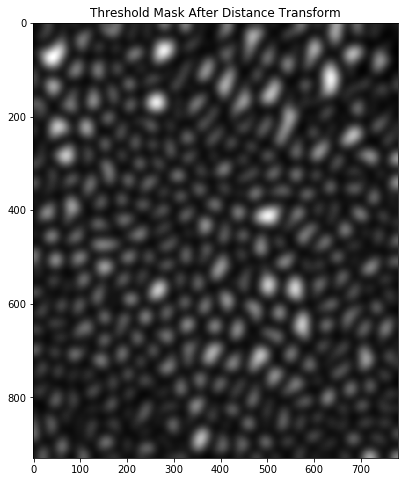

In [8]:
# Perform distance transform on binary threshold mask
# Note that it is unnecessary to use the labeled mask
dist_transf_mask = ndi.distance_transform_edt(better_threshold)
dist_transf_mask_smoothed = ndi.filters.gaussian_filter(dist_transf_mask, sigma=10)

# Plotting
plt.figure(figsize=(8,8))
plt.imshow(dist_transf_mask_smoothed, cmap='gray')
plt.title("Threshold Mask After Distance Transform")
plt.show()

#### 2. Seeding and Labeling
The seeds are then placed at the "brightest" points in the previous image and given unique labels:

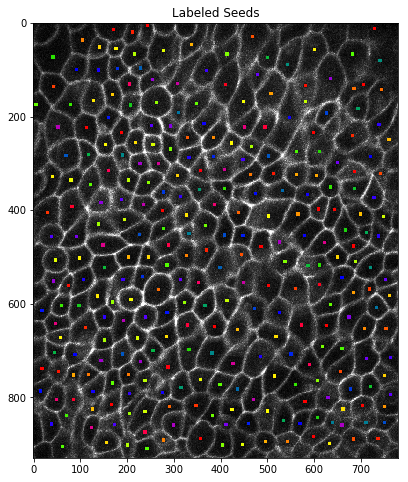

In [9]:
# Compute local maximum of each cell
seeds = skimage.feature.peak_local_max(dist_transf_mask_smoothed, indices=False)

# Make seeds larger so they are easier to see in the plot
seeds_max = ndi.filters.maximum_filter(seeds, size=7)

# Overlay seeds onto binary mask
seeds_mask_overlay = np.ma.array(seeds_max, mask=~seeds_max)

# Label the seeds
labeled_seeds, _ = ndi.label(seeds_max)

# Overlay seeds onto binary mask
labeled_seeds_mask_overlay = np.ma.array(labeled_seeds, mask=~seeds_max)

# Plotting
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.imshow(labeled_seeds_mask_overlay, cmap='prism')
plt.title('Labeled Seeds')
plt.show()

#### 3. Expansion by Watershed
Finally the watershed algorithm is performed on the labeled seeds data. Below we visualize the results!

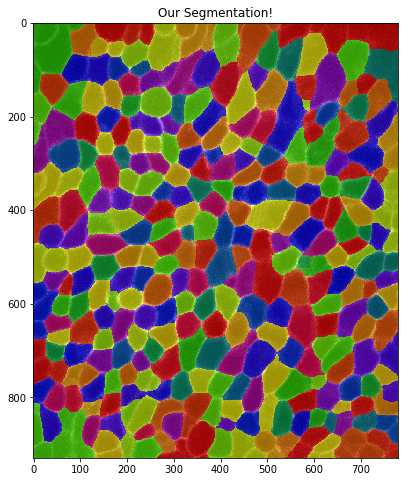

In [10]:
# Perform watershed expansion
cells = skimage.morphology.watershed(img_smoothed, labeled_seeds)

# Plotting
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.imshow(cells, alpha=.6, cmap='prism')
plt.title('Our Segmentation!')
plt.show()

## Postprocessing: Removing image border noise
So now we have a segmentation that looks pretty darn good! What's next?

Well for starters, it's probably a good idea to discard cells that are not fully contained within the field of view. An extremely important thing to note here is that by removing cells from the data we are *technically* modifying our experimental data. Since we aren't actually tampering with the data though, it's not such a big deal, but it's still an important point to consider, given that modifying experimental data is a big no-no!

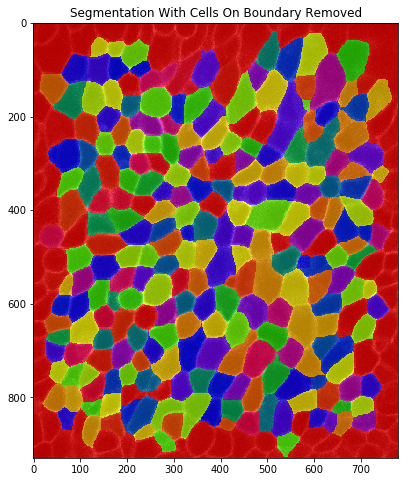

In [11]:
# Extract size of the original image
m,n = img_smoothed.shape

# Create binary mask of 1's along the border of the image
border_mask = ~ndi.binary_erosion(np.ones((m,n),dtype=np.int8))

# Create copy of each cell
cells_copy = np.copy(cells)

# Loop through cells and determine if they overlap with the border mask
for cell_id in np.unique(cells_copy)[1:]:
    # Create a mask that contains only the current cell of the iteration
    cell_mask = (cells_copy == cell_id)
    overlap = np.logical_and(cell_mask, border_mask)

    # If a cell touches the image boundary, delete it by setting its pixels in the segmentation to 0.
    if True in overlap:
        cells[cells_copy == cell_id] = 0

# Plotting
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.imshow(cells, alpha=0.7, cmap='prism')
plt.title('Segmentation With Cells On Boundary Removed')
plt.show()

## Postprocesing: Identifying cell edges
After removing cells touching the border we can finish up our postprocessing by creating a membrane mask for each cell. We do so by shrinking the mask of each cell by one pixel around the boundary and then using the complement of the "eroded" cell mask in order to create a border mask for each cell.

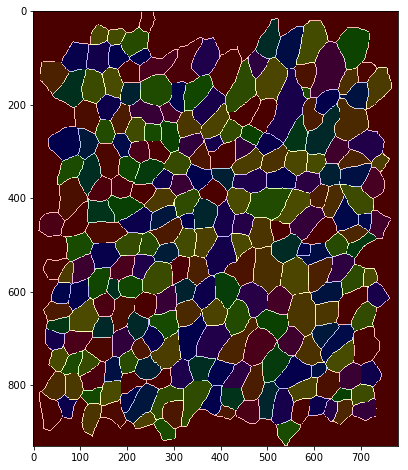

In [12]:
# Allocate empty array for cell edge masks
cell_membrane_mask = np.zeros(shape=(m,n))

# Loop through cells and create membrane masks
for cell_id in np.unique(cells):
    # Erode the cell's mask by 1 pixel
    cell_mask = (cells == cell_id)
    cell_mask_eroded = ndi.binary_erosion(cell_mask)

    # Create the cell edge mask
    mask = np.logical_xor(cell_mask, cell_mask_eroded)

    # Add the cell edge mask to the empty array generated above, labeling it with the cell's ID
    cell_membrane_mask = np.add(cell_membrane_mask, mask)

# Plotting
plt.figure(figsize=(8,8))
plt.imshow(cell_membrane_mask, cmap='gray')
plt.imshow(cells, alpha=0.3, cmap='prism')
plt.show()

### Image Analysis and Some Simple Visualizations
Okay great, we're ready for some data analysis! Following along with the tutorial we compute the following statistics for each cell:
1. Mean Intensity of Cell
2. Mean Intensity of Membrane
3. Cell Area
4. Membrane Area

The data is computed and stored in a dictionary below and then we finish up by doing some simple modeling and visualizations.

In [13]:
# Initialize dictionary to hold data
data = {
    'cell_id': [],
    'mean_intensity_cell': [],
    'mean_intensity_membrane': [],
    'cell_area': [],
    'cell_perimeter': []
}

# Extract Data
for cell_id in np.unique(cells)[1:]:
    # Compute cell_mask
    cell_mask = (cells == cell_id)
    cell_mask_eroded = ndi.binary_erosion(cell_mask)

    cell_edge_mask = np.logical_xor(cell_mask, cell_mask_eroded)

    data['cell_id'].append(cell_id)
    data['mean_intensity_cell'].append(np.mean(img[cell_mask]))
    data['mean_intensity_membrane'].append(np.mean(img[cell_edge_mask]))
    data['cell_area'].append(np.sum(cell_mask))
    data['cell_perimeter'].append(np.sum(cell_edge_mask))


### Boxplots, because duh!
So yeah, people like boxplots. I guess that's because they give a visual description of how "spread out" the data is. Here we make boxplots to visualize the mean intensity of the fluorescence for each cell and cell membrane.

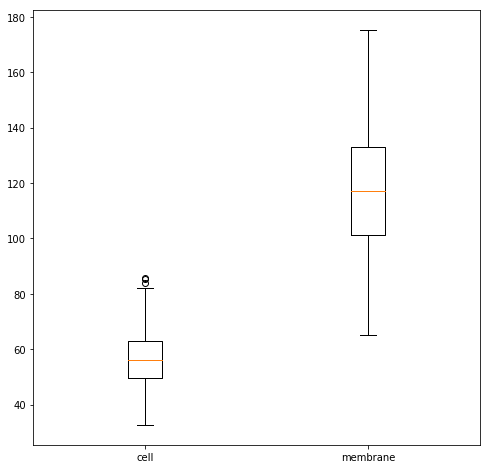

In [14]:
plt.figure(figsize=(8,8))
plt.boxplot([data['mean_intensity_cell'], data['mean_intensity_membrane']],labels=['cell','membrane'])
plt.show()

### A "Spherical Cell": Modeling cell area as a function of membrane length
Physicist's enjoy modeling poor farm animals as cows, hence the [spherical cow](https://en.wikipedia.org/wiki/Spherical_cow). 

But biologists deal with more complexity than the silly physicists. Does it make sense to extend the analogy to "spherical cells"? Here is a toy model to try and find out with a sample size of $N=1$ image. You can make a decision for yourself...

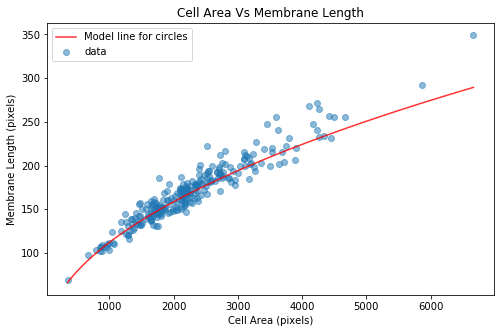

In [15]:
# Build curve to describe how the circumference of a circle varies as a function of area.
cell_area_range = np.linspace(min(data["cell_area"]), max(data["cell_area"]), num=100)
circle_circumference = 2 * np.pi * np.sqrt( cell_area_range / np.pi )

# Plotting
plt.figure(figsize=(8,5))
plt.scatter(data["cell_area"], data["cell_perimeter"], alpha=0.5)

plt.plot(cell_area_range, circle_circumference, color='r', alpha=0.8)
plt.legend(['Model line for circles', 'data'], loc=2, fontsize=10)
plt.xlabel('Cell Area (pixels)')
plt.ylabel('Membrane Length (pixels)')
plt.title('Cell Area Vs Membrane Length')
plt.show()

### Membrane intensity as a function of area
Here we apply simple linear regression to visualize the most basic model for predicting cell membrane intensity as a function of area. Why might we be interested in this model and is it even realistic? From my perspective, it's a pretty useless model on it's own as far as my ignorance allows me to imagine. That being said, I *can* imagine using the model to cluster cell types by establishing decision boundaries that partition the data with respect to the best fit line under some metric unbeknownst to me.

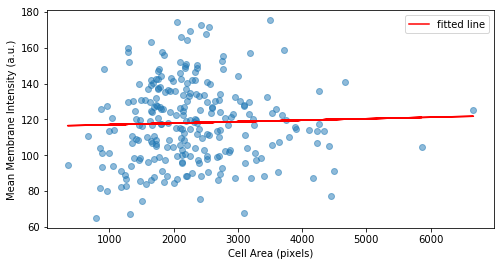

In [16]:
from scipy.stats import linregress

# Build linear regression model
slope, intercept, r_value, p_value, std_err = linregress(data['cell_area'], data['mean_intensity_membrane'])
y = data['mean_intensity_membrane']
x = data['cell_area']

# plt.scatter(data['mean_intensity_membrane'],data['cell_area'])
plt.figure(figsize=(8,4))
plt.scatter(x, y, alpha=0.5)
plt.plot(x, intercept + np.multiply(x,slope), 'r', label='fitted line')
plt.legend()
plt.xlabel("Cell Area (pixels)")
plt.ylabel("Mean Membrane Intensity (a.u.)")
plt.show()

### Visualizing Cell Area as a Heatmap
As mentioned in the previous section, the linear regression model on it's own is not so useful by itself. However, if we do some more data gymnastics maybe we can chain the linear model with a clustering algorithm to better understand if mean membrane intensity is a useful predictor for some particular functional behavior (as in, "are the cells with similar intensities doing something similar?"). Said another way, maybe we can differentiate functional behavior of subsets of cells in a local region by clustering cells in disjoint intervals in the spanning intensity space of the linear regression model (n.b. this is purely speculative and I didn't do the analysis since I'm not a biologist, am not sure where the data came from, and would need more context to get into functional analysis. But it seemed like an interesting idea :)

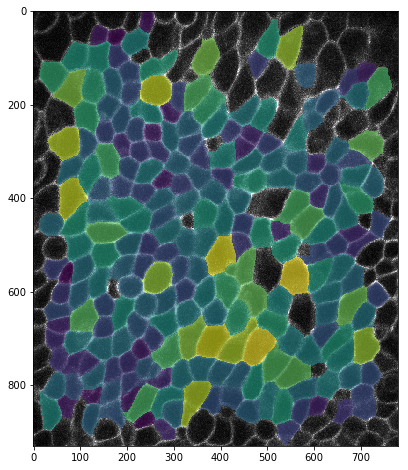

In [17]:
# Rescale pixel data to type Uint8 
scale = max(np.array(data['cell_area']))
cell_area_data = np.array(data['cell_area']) / max(data["cell_area"]) * 255

# Initialize empty array for heat map.
img_arr = np.zeros_like(img, dtype=np.uint8)

# Iterate over the segmented cells.
for i, cell in enumerate(data['cell_id']):
    # Mask the current cell and assign the cell's (re-scaled) area value to the cell's pixels.
    mask = cells == cell
    img_arr[mask] = cell_area_data[i]

# Mask of outliers (the largest and smallest 5% of all cells)
outlier_mask = np.logical_or(img_arr > np.percentile(cell_area_data, 95),
                             img_arr < np.percentile(cell_area_data, 5))

# Mask of all regions to leave blank (outliers + image boundary cells)
full_mask = np.logical_or(img_arr==0, outlier_mask)

plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.imshow(np.ma.array(img_arr, mask=full_mask), alpha=0.6)
plt.show()